# Importing all the necessary libraries

In [1]:
# basic libraries
import copy
import os
import threading
import time
from lib2to3.pgen2.tokenize import tokenize

import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers

# libraries for the model training and dataset loading
from datasets import load_dataset
from keras.src.metrics.accuracy_metrics import accuracy
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
from transformers import get_scheduler
import torch
from torch.utils.data import Dataset, DataLoader

# LoRA library from Microsoft (https://github.com/microsoft/LoRA/tree/main)
import loralib

# files with custom Bert model and the changed file from transformers library
import bert_multi_lora
from custom_model import CustomBert, LoRABert

C:\Users\balanton\AppData\Local\Temp\ipykernel_10844\1634781091.py:6: DeprecationWarning: lib2to3 package is deprecated and may not be able to parse Python 3.10+
  from lib2to3.pgen2.tokenize import tokenize
C:\Users\balanton\anaconda3\envs\semester_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# uncomment the below line if you want to automatically reload the modules
# though this will disable debugging in the notebook

# %load_ext autoreload
# %autoreload 2

In [3]:
# setting device to `cuda` if gpu exists
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [4]:
model_name = "google-bert/bert-base-uncased"

# model is initialized from the custom file since it has the masking functionality
bert = bert_multi_lora.BertModel.from_pretrained(model_name, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Custom model finetuning

## Dataset and Dataloaders

In [5]:
class MultiAdapterDataset(Dataset):
    """
    Dataset class for the custom dataset that will be used for training and evaluation.
    """
    
    def __init__(self, datasets, lora_cnt=2, id=None):
        """
        Constructor for the class.
        
        :param datasets: datasets that will be used to train and evaluate respective adapters
        :param lora_cnt: number of adapters
        :param id: id of the adapter (& dataset) that will be used for the evaluation. If None, the dataset is used for training
        """
        self.datasets = datasets
        self.id = id
        self.lora_cnt = lora_cnt

    def __len__(self):
        """
        Function to get the length of the dataset.
        
        :return: length of the dataset. If id is not None, the length of the dataset with the given id is returned, otherwise the sum of the lengths of all datasets is returned
        """
        if self.id is not None:
            return len(self.datasets[0])
        else:
            return sum([len(d) for d in self.datasets])

    def __getitem__(self, idx):
        """
        Function to get the item from the dataset.
        
        :param idx: index of the item
        :return: item from the dataset. If id is not None, the item from the dataset with the given id is returned, otherwise the item from the dataset with the index (idx % lora_cnt) is returned
        """
        
        # masking is used to determine which adapter is used for the given item, it is 1 for the adapter that is used and 0 for the other adapters
        masking = torch.zeros(self.lora_cnt)
        
        if self.id is not None: 
            masking[self.id] = 1
            d = self.datasets[0][idx]
        else:
            masking[idx % self.lora_cnt] = 1
            d = self.datasets[idx % self.lora_cnt][idx // self.lora_cnt]
        
        ids = torch.tensor(d['input_ids'])
        mask = torch.tensor(d['attention_mask'])
        label = torch.tensor(d['label'])
        
        return ids, mask, label, masking

In [6]:
# here we define the tokenization functions for the datasets, different functions are used for different datasets as the structure of the datasets is different
def tokenize_imdb(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

def tokenize_rotten_tomatoes(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

def tokenize_amazon(examples):
    return tokenizer(examples["content"], padding="max_length", truncation=True, max_length=128)


def get_tokenized_datasets(paths, functions, split="train", batched=True, num_samples=1000):
    """
    Function to get the tokenized datasets.
    
    :param paths: paths to the datasets, can be local paths or the names of the datasets from the Hugging Face library
    :param functions: functions that will be used to tokenize the datasets
    :param split: split of the dataset that will be used, can be "train" or "test"
    :param batched: whether the tokenization should be batched
    :param num_samples: number of samples that will be used from each dataset
    :return: list of tokenized datasets
    """
    datasets = [load_dataset(path) for path in paths]
    tokenized_datasets = [dataset.map(function, batched=batched)[split].shuffle(seed=42).select(range(num_samples)) for dataset, function in zip(datasets, functions)]
    return tokenized_datasets

def get_dataloaders(tokenized_datasets, lora_cnt, split="train", batch_size=16):
    """
    Function to get the dataloaders for the datasets.
    
    :param tokenized_datasets: tokenized datasets
    :param lora_cnt: number of adapters
    :param split: split of the dataset that will be used, can be "train" or "test"
    :param batch_size: batch size
    :return: list of dataloaders
    """
    # if the split is "train", only one dataloader is returned, otherwise a list of dataloaders is returned
    if split=="train":
        dataset = MultiAdapterDataset(tokenized_datasets, lora_cnt=lora_cnt)
        return DataLoader(dataset, shuffle=False, batch_size=batch_size)
    elif split=="test":
        datasets = [MultiAdapterDataset([tokenized_datasets[i]], lora_cnt=lora_cnt, id=i) for i in range(lora_cnt)]
        return [DataLoader(dataset, shuffle=False, batch_size=batch_size) for dataset in datasets]
    else:
        raise ValueError("Invalid split")

In [7]:
datasets = ["imdb", "fancyzhx/amazon_polarity", "cornell-movie-review-data/rotten_tomatoes"]
functions = [tokenize_imdb, tokenize_amazon, tokenize_rotten_tomatoes]

## Defining the model

In [8]:
# Define LoRA parameters
num_adapters = len(datasets)
num_samples = 1024
rank = 8
alpha = 8

# Initialize the custom model
model = CustomBert(copy.deepcopy(bert), num_adapters=num_adapters, rank=rank, alpha=alpha).to(device)

## Initial evaluation

In [9]:
tokenized_test = get_tokenized_datasets(datasets, functions, num_samples=num_samples, split="test")

test_loaders = get_dataloaders(tokenized_test, num_adapters, split="test")

In [10]:
# Evaluate both adapters on respective datasets
model.eval()
criterion = torch.nn.BCELoss()

for i in range(num_adapters):
    total_loss = 0
    for batch in test_loaders[i]:
        ids, masks, labels, masking = batch
        labels = labels.type(torch.float)
        o = model(ids.to(device), masks.to(device), masking.to(device))
        loss = criterion(torch.squeeze(o), labels.to(device))

        total_loss += loss.item()

    print(f"Adapter {i} loss: {total_loss / len(test_loaders[i])}")

Adapter 0 loss: 0.698785443790257
Adapter 1 loss: 0.7059074295684695
Adapter 2 loss: 0.7004719730466604


## Training

In [11]:
tokenized_datasets = get_tokenized_datasets(datasets, functions, num_samples=num_samples, split="train")

train_dataloader = get_dataloaders(tokenized_datasets, num_adapters, split="train")

In [12]:
# Training loop
model.train()
criterion = torch.nn.BCELoss()

# Mark only LoRA parameters as trainable
for name, param in model.named_parameters():
    if "adapter" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer = AdamW(model.parameters(), lr=5e-6, weight_decay=0)

num_epochs = 50
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [13]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.requires_grad)

bert.encoder.layer.0.attention.self.query.adapters.0.lora_A True
bert.encoder.layer.0.attention.self.query.adapters.0.lora_B True
bert.encoder.layer.0.attention.self.query.adapters.1.lora_A True
bert.encoder.layer.0.attention.self.query.adapters.1.lora_B True
bert.encoder.layer.0.attention.self.query.adapters.2.lora_A True
bert.encoder.layer.0.attention.self.query.adapters.2.lora_B True
bert.encoder.layer.0.attention.self.key.adapters.0.lora_A True
bert.encoder.layer.0.attention.self.key.adapters.0.lora_B True
bert.encoder.layer.0.attention.self.key.adapters.1.lora_A True
bert.encoder.layer.0.attention.self.key.adapters.1.lora_B True
bert.encoder.layer.0.attention.self.key.adapters.2.lora_A True
bert.encoder.layer.0.attention.self.key.adapters.2.lora_B True
bert.encoder.layer.0.attention.self.value.adapters.0.lora_A True
bert.encoder.layer.0.attention.self.value.adapters.0.lora_B True
bert.encoder.layer.0.attention.self.value.adapters.1.lora_A True
bert.encoder.layer.0.attention.self.v

In [15]:
def train(data):
    ids, masks, labels, masking = data
    labels = labels.type(torch.float)

    o = model(ids.to(device), masks.to(device), masking.to(device)) 

    loss = criterion(torch.squeeze(o), labels.to(device))
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()  
    lr_scheduler.step()

In [16]:
losses = []
accuracies = []

start = time.time()

for epoch in tqdm.tqdm(range(num_epochs), desc="Training"):
    running_loss = 0.0
    
    for i, batch in enumerate(train_dataloader):    
        ids, masks, labels, masking = batch
        labels = labels.type(torch.float).to(device)
    
        o = model(ids.to(device), masks.to(device), masking.to(device)) 
    
        loss = criterion(torch.squeeze(o), labels)
        loss.backward()
    
        optimizer.step()  
        lr_scheduler.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        
    losses.append(running_loss / len(train_dataloader))
        
print(f"Training time: {time.time() - start}")

Training: 100%|██████████| 50/50 [21:46<00:00, 26.13s/it]

Training time: 1306.630577325821


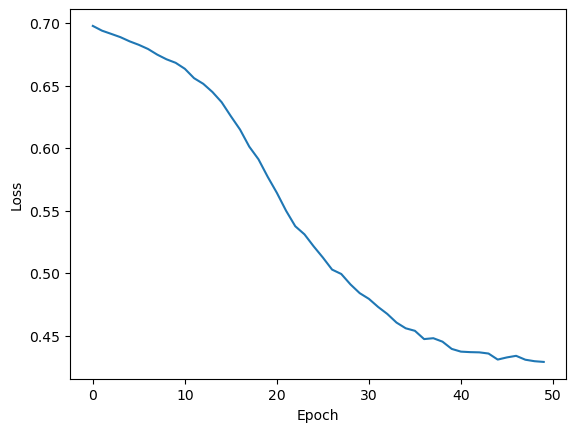

In [18]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Evaluation

In [19]:
# Evaluate both adapters on respective datasets
model.eval()

for i in range(num_adapters):
    total_loss = 0
    for batch in test_loaders[i]:
        ids, masks, labels, masking = batch
        labels = labels.type(torch.float)
        o = model(ids.to(device), masks.to(device), masking.to(device))
        # o = model(ids.to(device), masks.to(device), torch.tensor(i).to(device))
        loss = criterion(torch.squeeze(o), labels.to(device))
        
        total_loss += loss.item()
        
    print(f"Adapter {i} loss: {total_loss / len(test_loaders[i])}")

Adapter 0 loss: 0.5022003222256899
Adapter 1 loss: 0.3347455847542733
Adapter 2 loss: 0.4473282548133284


## Saving the model

In [20]:
# save the tokenizer and the model in `./test-model/` directory 
# tokenizer.save_pretrained("./test-model/")
# model.save_pretrained("./test-model/", push_to_hub=False)

# LoRA model finetuning

In [21]:
num_adapters = len(datasets)

bert_normal = AutoModel.from_pretrained(model_name, device_map="auto")
loraBerts = [LoRABert(copy.deepcopy(bert_normal)).to(device) for _ in range(num_adapters)]

criterion = torch.nn.BCELoss()

# Mark only LoRA parameters as trainable
for i in range(num_adapters):
    for name, param in loraBerts[i].named_parameters():
        if "lora" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

## Initial evaluation

In [22]:
tokenized_test = get_tokenized_datasets(datasets, functions, num_samples=num_samples, split="test")

test_loaders = get_dataloaders(tokenized_test, num_adapters, split="test")

for i in range(num_adapters):
    loraBerts[i].eval()
    total_loss = 0
    for batch in test_loaders[i]:
        ids, masks, labels, _ = batch
        labels = labels.type(torch.float)
        o = loraBerts[i](ids.to(device), masks.to(device))
        loss = criterion(torch.squeeze(o), labels.to(device))
        
        total_loss += loss.item()
        
    print(f"Adapter {i} loss: {total_loss / len(test_loaders[i])}")

Adapter 0 loss: 0.6931545687839389
Adapter 1 loss: 0.6981197809800506
Adapter 2 loss: 0.6902256393805146


## Training

In [23]:
# Training loop
for i in range(num_adapters):
    loraBerts[i].train()
    
criterion = torch.nn.BCELoss()

tokenized_datasets = get_tokenized_datasets(datasets, functions, num_samples=num_samples, split="train")
train_dataloaders = get_dataloaders(tokenized_datasets, num_adapters, split="test")

num_epochs = num_epochs
optimizers = [AdamW(loraBerts[i].parameters(), lr=5e-6, weight_decay=0) for i in range(num_adapters)]
num_training_steps = [num_epochs * len(train_dataloaders[i]) for i in range(num_adapters)]
lr_schedulers = [get_scheduler("linear", optimizer=optimizers[i], num_warmup_steps=0, num_training_steps=num_training_steps[i]) for i in range(num_adapters)]

In [24]:
start = time.time()

for i in range(num_adapters):
    for epoch in tqdm.tqdm(range(num_epochs)):
        for batch in train_dataloaders[i]:
            ids, masks, labels, _ = batch
            labels = labels.type(torch.float)
            o = loraBerts[i](ids.to(device), masks.to(device))

            loss = criterion(torch.squeeze(o), labels.to(device))
            loss.backward()

            optimizers[i].step()
            optimizers[i].zero_grad()
            lr_schedulers[i].step()

print(f"Training time: {time.time() - start}")

100%|██████████| 10/10 [01:09<00:00,  6.99s/it]

Training time: 214.45205950737


## Evaluation

In [25]:
for i in range(num_adapters):
    loraBerts[i].eval()
    total_loss = 0
    for batch in test_loaders[i]:
        ids, masks, labels, _ = batch
        labels = labels.type(torch.float)
        o = loraBerts[i](ids.to(device), masks.to(device))
        loss = criterion(torch.squeeze(o), labels.to(device))
        
        total_loss += loss.item()
        
    print(f"Adapter {i} loss: {total_loss / len(test_loaders[i])}")

Adapter 0 loss: 0.6923950416967273
Adapter 1 loss: 0.696713755838573
Adapter 2 loss: 0.6894992822781205
